In [1]:
import os
import time

from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

import jax
from jax import numpy as jnp
from jax import random

import optax

from src.QDDPM_jax import QDDPM, HaarSampleGeneration
from src.distance_jax import naturalDistance, sinkhornDistance

# rc('text', usetex=True)
# rc('axes', linewidth=3)

2023-11-11 06:50:53.864080: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Please first ``pip install -U qiskit`` to enable related functionality in translation module
Please first ``pip install -U cirq`` to enable related functionality in translation module


In [2]:
# check device
print(jax.lib.xla_bridge.get_backend().platform)

gpu


In [3]:
def Training_t(model, t, inputs_T, params_tot, epochs, dis_measure='wd'):
    '''
    training for the backward PQC at step t using whole dataset
    Args:
    model: QDDPM model
    t: diffusion step
    params_tot: collection of PQC parameters for steps > t 
    epochs: number of iterations
    dis_measure: the distance measure to compare two distributions of quantum states
    dis_params: potential hyper-parameters for distance measure
    '''
    Ndata = inputs_T.shape[0]

    input_tplus1 = model.prepareInput_t(
        inputs_T, params_tot, t, Ndata)  # prepare input
    states_diff = model.states_diff
    loss_hist = []  # record of training history

    # initialize parameters
    key = random.PRNGKey(np.random.randint(low=0, high=10000))
    param_shape = 2 * model.n_tot * model.L
    params_t = random.normal(key, shape=(param_shape, ))

    # set optimizer and learning rate decay
    optimizer = optax.adam(learning_rate=1e-3)
    opt_state = optimizer.init(params_t)

    if dis_measure == 'nat':
        dist_func = naturalDistance

    elif dis_measure == 'wd':
        dist_func = sinkhornDistance

    def loss_func(params_t, input_tplus1, true_data):
        output_t = model.backwardOutput_t(input_tplus1, params_t)
        loss = dist_func(output_t, true_data)

        return loss

    loss_func_vg = jax.jit(jax.value_and_grad(loss_func))

    def update(params_t, input_tplus1, true_data, opt_state):
        loss_value, grads = loss_func_vg(params_t, input_tplus1, true_data)
        updates, new_opt_state = optimizer.update(grads, opt_state, params_t)
        new_params_t = optax.apply_updates(params_t, updates)

        return new_params_t, new_opt_state, loss_value

    t0 = time.time()
    for step in range(epochs):
        np.random.seed()
        indices = np.random.choice(
            states_diff.shape[1], size=Ndata, replace=False)
        true_data = states_diff[t, indices]

        params_t, opt_state, loss_value = update(
            params_t, input_tplus1, true_data, opt_state)

        # if step % 500 == 0:
        #     print("Step {}, loss: {:.7f}, time elapsed: {:.4f} seconds".format(
        #         step, loss_value, time.time() - t0))

        loss_hist.append(loss_value)  # record the current loss

    return params_t, loss_hist

In [4]:
n, na = 4, 2
T = 30
L = 12

Ndata = 100
epochs = 2001

inputs_T = HaarSampleGeneration(Ndata, 2 ** n, seed=42)
states_diff = jnp.load('data/tfim/tfimDiff_n4T30_N10000.npy')
# states_diff = jnp.load('data/cluster/cluster0Diff_n6T20_N10000.npy')

In [5]:
model = QDDPM(n=n, na=na, T=T, L=L)
model.set_diffusionSet(states_diff)

In [6]:
loss_list = []
params_tot = jnp.zeros((T, 2 * (n + na) * L))

t0 = time.time()
for t in range(T - 1, -1, -1):
    params, loss = Training_t(model, t, inputs_T, params_tot, epochs, 'nat')
    params_tot = params_tot.at[t].set(params)
    loss_list.append(loss)
    # clear_output(wait=True)
    print("==========================================================")
    print("Iteration {} done, time elapsed: {:.4f} seconds".format(t, time.time() - t0))

Iteration 29 done, time elapsed: 24.6745 seconds
Iteration 28 done, time elapsed: 48.6770 seconds
Iteration 27 done, time elapsed: 69.7124 seconds
Iteration 26 done, time elapsed: 91.7562 seconds
Iteration 25 done, time elapsed: 120.0237 seconds
Iteration 24 done, time elapsed: 140.7247 seconds
Iteration 23 done, time elapsed: 162.1308 seconds
Iteration 22 done, time elapsed: 184.2442 seconds
Iteration 21 done, time elapsed: 206.4430 seconds
Iteration 20 done, time elapsed: 230.0633 seconds
Iteration 19 done, time elapsed: 252.6628 seconds
Iteration 18 done, time elapsed: 276.6299 seconds
Iteration 17 done, time elapsed: 299.1955 seconds
Iteration 16 done, time elapsed: 322.2632 seconds
Iteration 15 done, time elapsed: 346.0309 seconds
Iteration 14 done, time elapsed: 368.6958 seconds
Iteration 13 done, time elapsed: 392.1776 seconds
Iteration 12 done, time elapsed: 416.1040 seconds
Iteration 11 done, time elapsed: 439.0812 seconds
Iteration 10 done, time elapsed: 461.7918 seconds
Iter

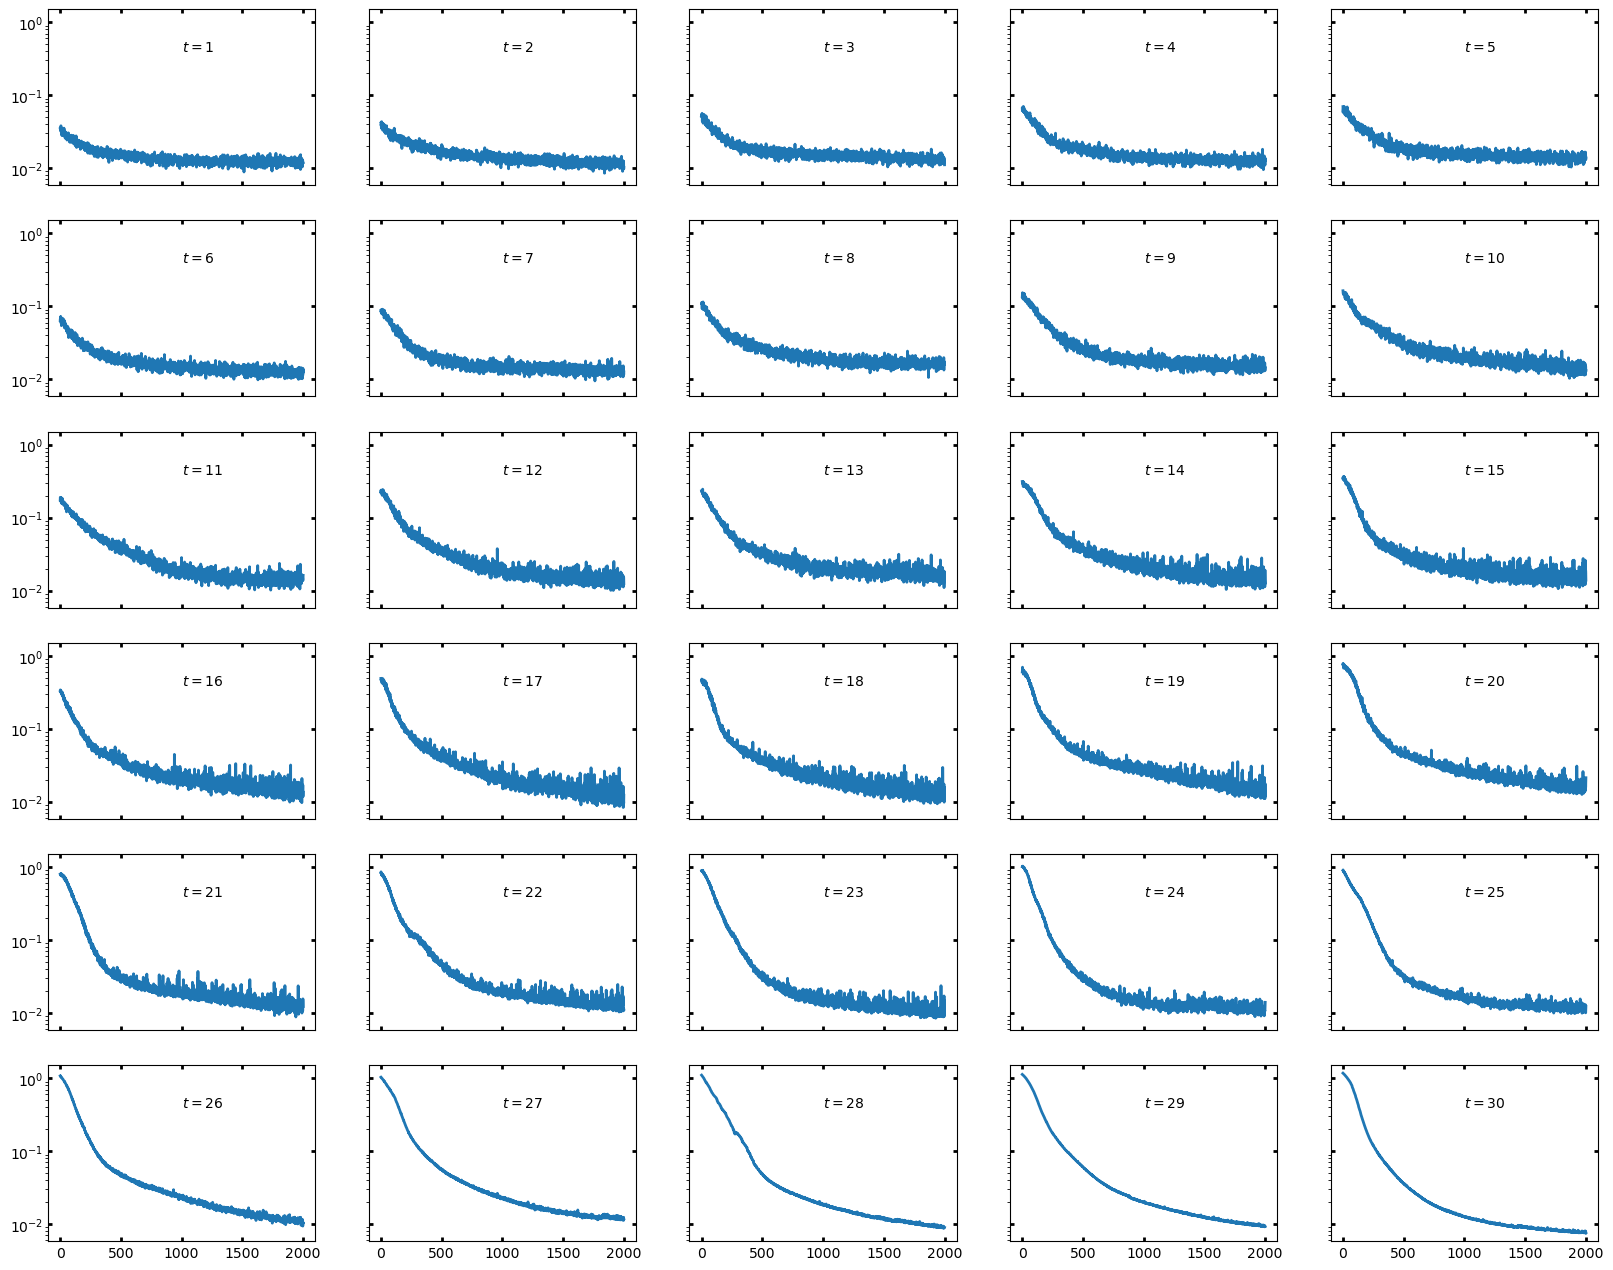

In [7]:
fig, axs = plt.subplots(6, 5, figsize=(20, 16), sharex=True, sharey=True)
for i in range(T):
    axs[i // 5, i % 5].plot(loss_list[i], lw=2)
    axs[i // 5, i % 5].tick_params(direction='in', length=3, width=2, top='on', right='on', labelsize=10)
    axs[i // 5, i % 5].text(x=1000, y=0.4, s=r'$t=%d$'%(i+1), fontsize=10)
    axs[i // 5, i % 5].set_yscale('log')

In [8]:
jnp.save('data/tfim/tfimDiff_n4T30_N100_param.npy', params_tot)